# Network Intrusion Detection System - NIDS

# 1. Prerequisites

## 1.1. Import Libraries

In [1]:
import os
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

2025-01-25 18:01:40.941768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737820901.001485    4530 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737820901.021233    4530 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 18:01:41.153445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/prepared_train_labels.npy
data/CIC_IDS_2017/MachineLearningCSV.md5
data/CIC_IDS_2017/download_dataset.sh
data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/prepared_train_data.npy
data/CIC_IDS_2017/GeneratedLabelledFlows.zip
data/CIC_IDS_2017/MachineLearningCSV.zip
data/CIC_IDS_2017/GeneratedLabelledFlows.md5
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_20

# 2. Data Analysis

In [3]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [4]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [5]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
data[' Flow Duration'].head(20)

0         4
1         1
2         1
3         1
4         3
5         1
6         1
7         1
8       609
9       879
10     1160
11      524
12        6
13     1119
14    18378
15      822
16      876
17     1009
18      616
19        5
Name:  Flow Duration, dtype: int64

In [7]:
data[' Label']

0         BENIGN
1         BENIGN
2         BENIGN
3         BENIGN
4         BENIGN
           ...  
286462    BENIGN
286463    BENIGN
286464    BENIGN
286465    BENIGN
286466    BENIGN
Name:  Label, Length: 2830743, dtype: object

In [8]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [10]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [12]:
data[' Class'] = ["BENIGN" if x=='BENIGN' else "MALICIOUS" for x in data[' Label']]

In [13]:
labels = data[' Label'].unique()
values = data[' Label'].value_counts()

In [14]:
def unique_attacks(df, table_name, labels, values):
    """
    Print unique attack labels and count in the dataset
    """
    table = PrettyTable(["Label", "Count"])
    for label, value in zip(labels, values):
        table.add_row([label, value])
    info = table.get_string()
    with open(f"tables/{table_name}.txt", 'w') as f:
        f.write(info)
    print(table)
    print(f"Table saved as {table_name}.txt")

In [15]:
unique_attacks(data, "Unique_attacks", labels, values)

+----------------------------+---------+
|           Label            |  Count  |
+----------------------------+---------+
|           BENIGN           | 2273097 |
|        FTP-Patator         |  231073 |
|        SSH-Patator         |  158930 |
|       DoS slowloris        |  128027 |
|      DoS Slowhttptest      |  10293  |
|          DoS Hulk          |   7938  |
|       DoS GoldenEye        |   5897  |
|         Heartbleed         |   5796  |
|  Web Attack � Brute Force  |   5499  |
|      Web Attack � XSS      |   1966  |
| Web Attack � Sql Injection |   1507  |
|        Infiltration        |   652   |
|            DDoS            |    36   |
|            Bot             |    21   |
|          PortScan          |    11   |
+----------------------------+---------+
Table saved as Unique_attacks.txt


In [16]:
def missing_values(df, table_name):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    with open(f"tables/{table_name}.txt", 'w') as f:
        f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    print(f"Table saved as {table_name}.txt")

In [17]:
data = data.replace([-np.inf, np.inf], np.nan)
missing_values(data, "Missing_data")

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [18]:
data.dropna(inplace=True)
missing_values(data, "Updated_data")

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

# Plots

In [32]:
def pair_plot(df, hue, plot_name):
    selected_features=[' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', hue]
    pairplot = sns.pairplot(df[selected_features], hue=hue)
    plt.show()
    fig = pairplot.fig
    fig.savefig(f"images/plots/{plot_name}.png")

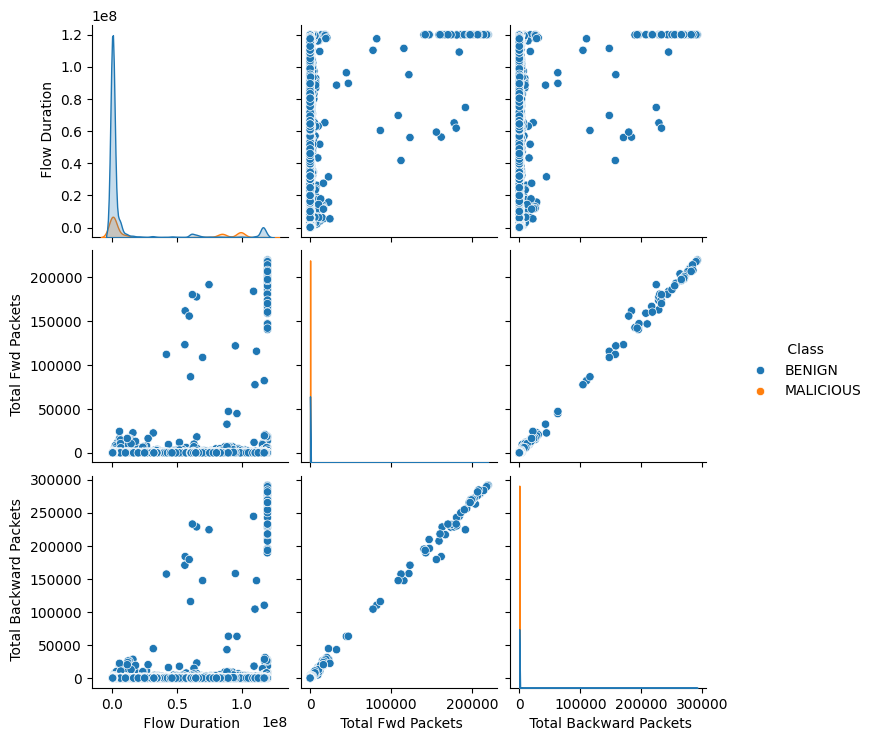

CPU times: user 16min 28s, sys: 2.94 s, total: 16min 31s
Wall time: 16min 27s


In [33]:
%%time
pair_plot(data, ' Class', "Pairplot")

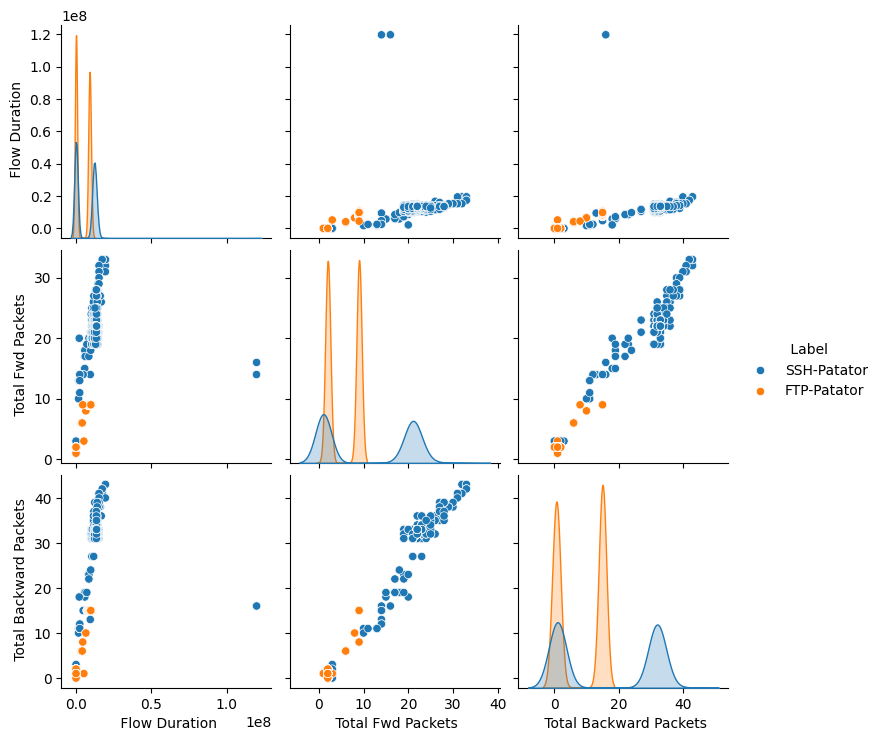

In [34]:
frames = [
    data[data[' Label']=="SSH-Patator"],
    data[data[' Label']=="FTP-Patator"]
]

df = pd.concat(frames)

pair_plot(df, ' Label', "Patator-Pairplot")

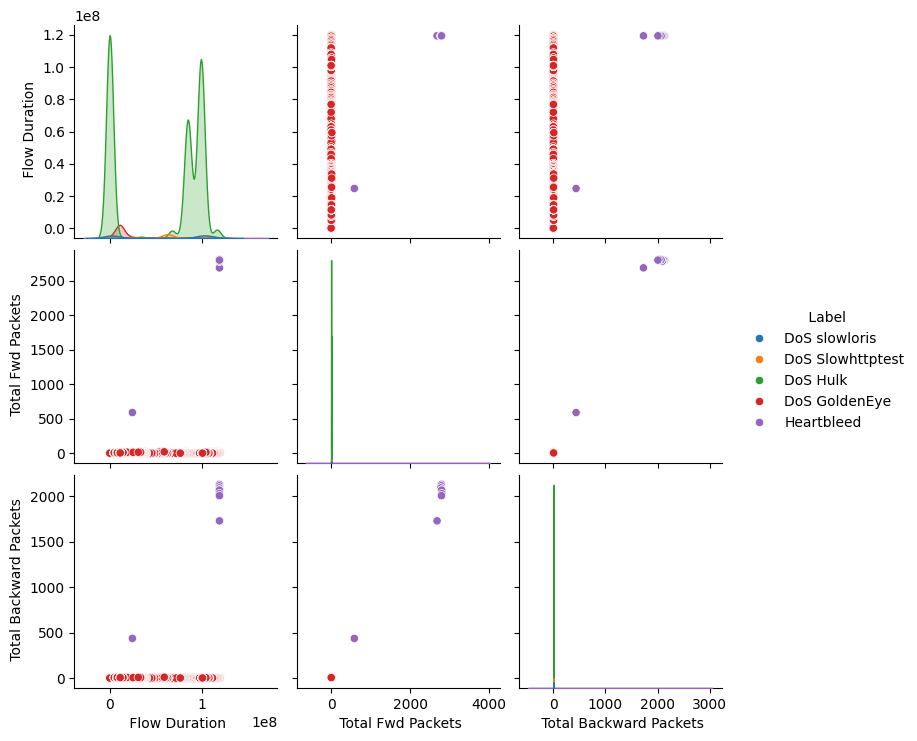

In [35]:
frames = [
    data[data[' Label']=='DoS slowloris'],
    data[data[' Label']=='DoS Slowhttptest'],
    data[data[' Label']=='DoS Hulk'],
    data[data[' Label']=='DoS GoldenEye'],
    data[data[' Label']=='Heartbleed']
]

df = pd.concat(frames)

pair_plot(df, ' Label', "DDoS-Attack-Pairplot")

In [23]:
def traffic_plot(label, count):
    # count[0] - benign record count
    # s - malicious record count
    s = 0
    for i in range(1,len(count)):
        s = s + count[i]
    labels = ["Benign", "Malicious"]
    counts = [count[0], s]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(labels, counts)
    rects = ax.patches
    labels = [f"Label: {labels[i]}, Records: {counts[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Network traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Network traffic type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Traffic_type_distribution.png")

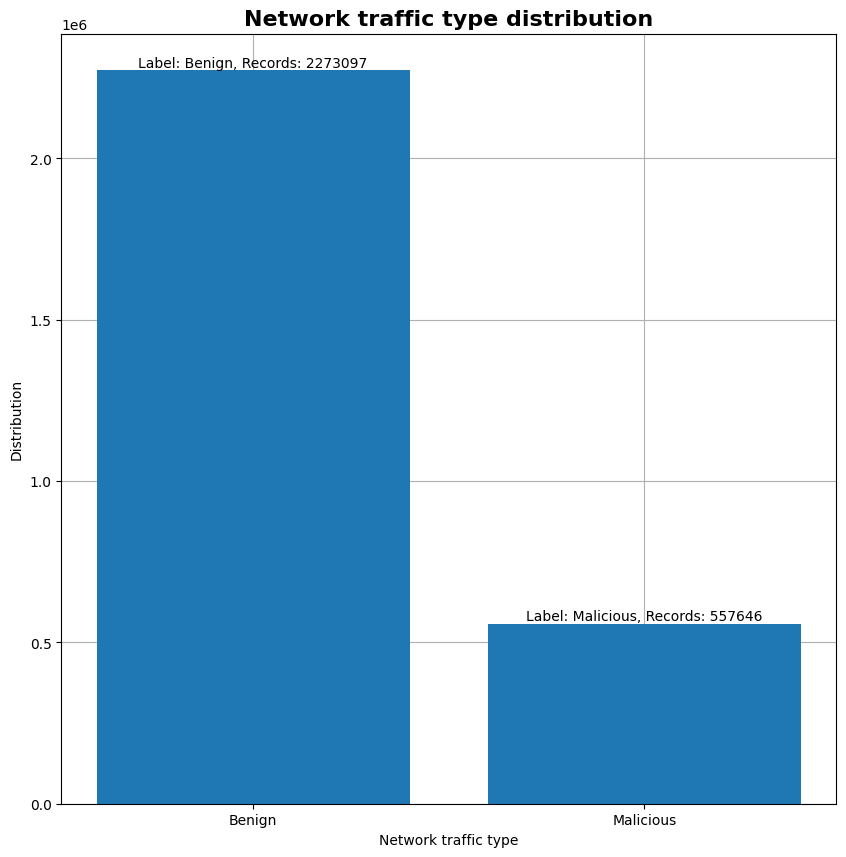

In [24]:
traffic_plot(labels, values)

In [22]:
labels

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [37]:
def attack_plot(labels, count):
    _dict, attacks = [{} for x in range(2)]
    label = [x for x in labels if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    _dict["XSS"] = _dict["Web Attack � XSS"]
    _dict["SQL Injection"] = _dict["Web Attack � Sql Injection"]
    _dict["Brute Force"] = _dict["Web Attack � Brute Force"]
    del _dict["Web Attack � XSS"]
    del _dict["Web Attack � Sql Injection"]
    del _dict["Web Attack � Brute Force"]
    tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    labels = [f"{count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Attack_type_distribution.png")

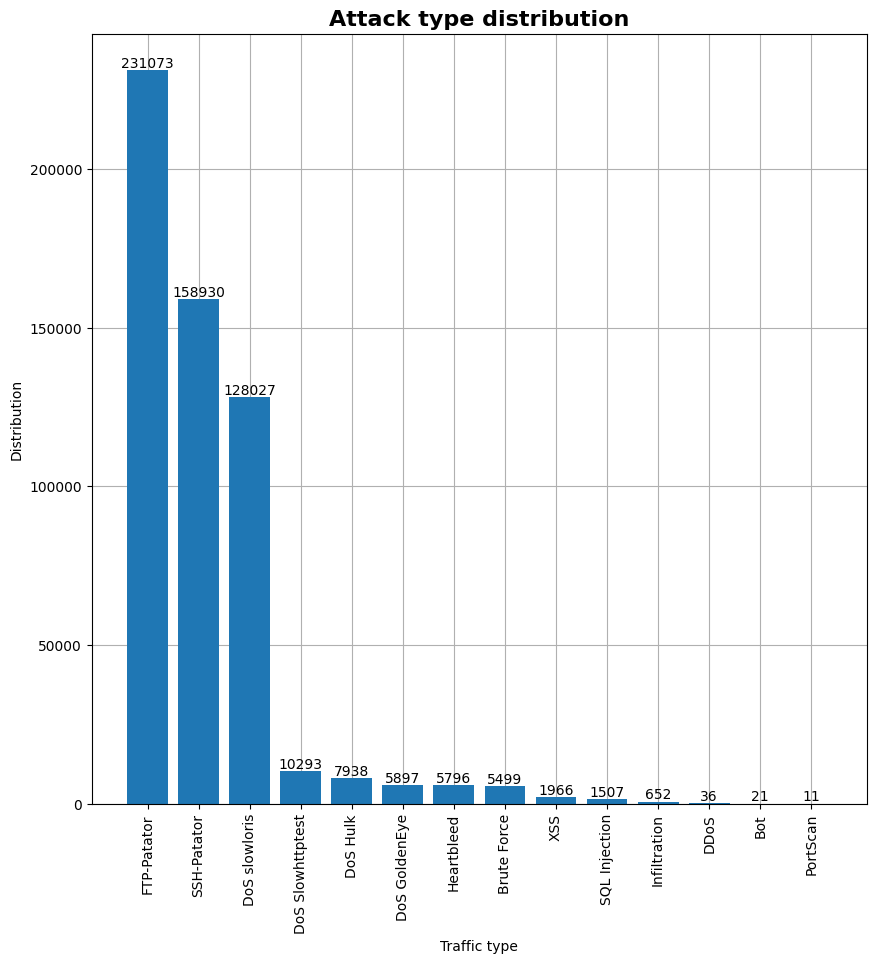

In [38]:
attack_plot(labels, values)

In [42]:
def patator_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    rects = ax.patches
    labels = [f"Label: {label[i]}, Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Patator attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Patator attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Patator_attack_distribution.png")

In [43]:
frames = [
    data[data[' Label']=="SSH-Patator"],
    data[data[' Label']=="FTP-Patator"]
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

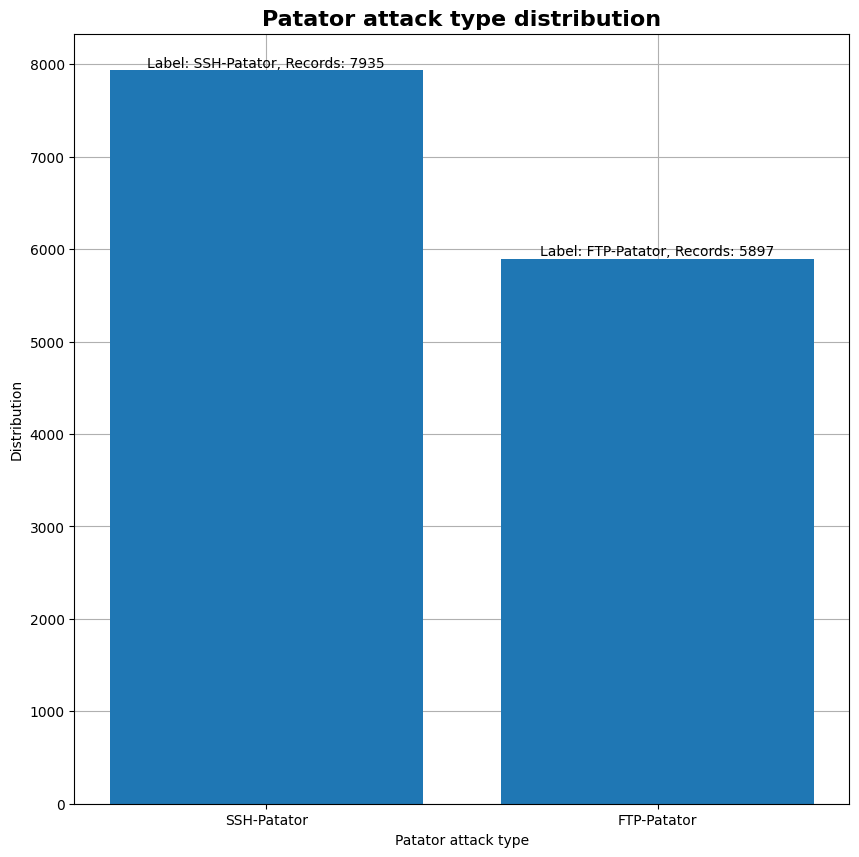

In [44]:
patator_plot(label, count)

In [48]:
def web_plot(label, count):
    _dict, attacks = [{} for x in range(2)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    _dict["XSS"] = _dict["Web Attack � XSS"]
    _dict["SQL Injection"] = _dict["Web Attack � Sql Injection"]
    _dict["Brute Force"] = _dict["Web Attack � Brute Force"]
    del _dict["Web Attack � XSS"]
    del _dict["Web Attack � Sql Injection"]
    del _dict["Web Attack � Brute Force"]
    tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    labels = [f"Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Web attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Web attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Web_attack_distribution.png")

In [49]:
frames = [
    data[data[' Label']=='Web Attack � Brute Force'],
    data[data[' Label']=='Web Attack � XSS'],
    data[data[' Label']=='Web Attack � Sql Injection']
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

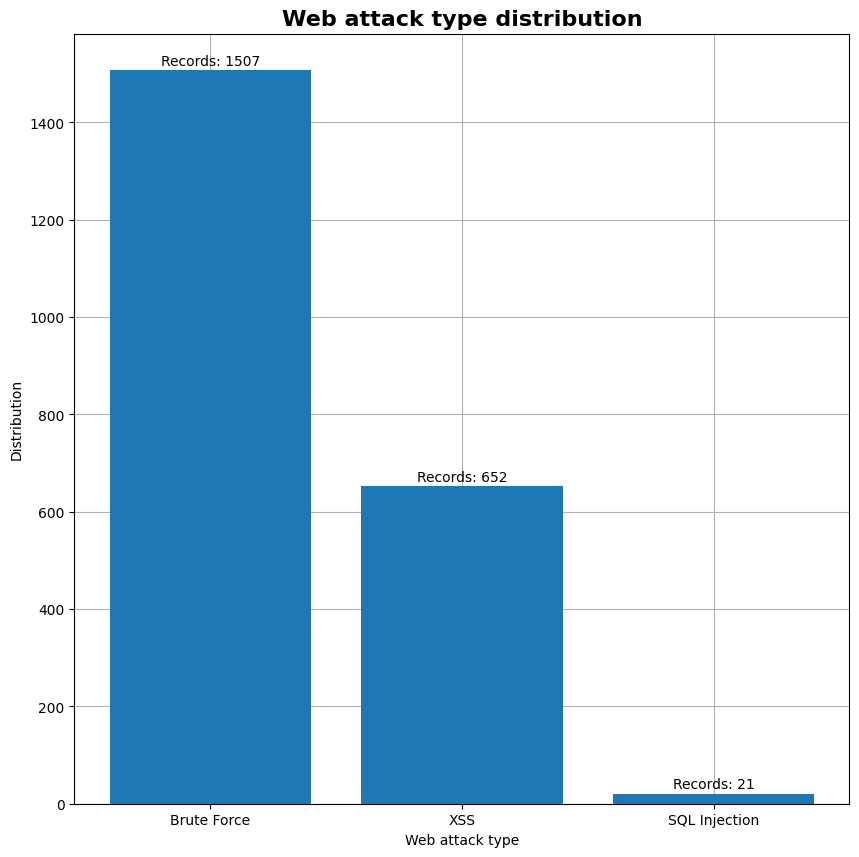

In [50]:
web_plot(label, count)

In [51]:
def dos_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    rects = ax.patches
    labels = [f"Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('DDoS attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('DDoS attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/DDoS_attack_distribution.png")

In [52]:
frames = [
    data[data[' Label']=='DoS slowloris'],
    data[data[' Label']=='DoS Slowhttptest'],
    data[data[' Label']=='DoS Hulk'],
    data[data[' Label']=='DoS GoldenEye'],
    data[data[' Label']=='Heartbleed']
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

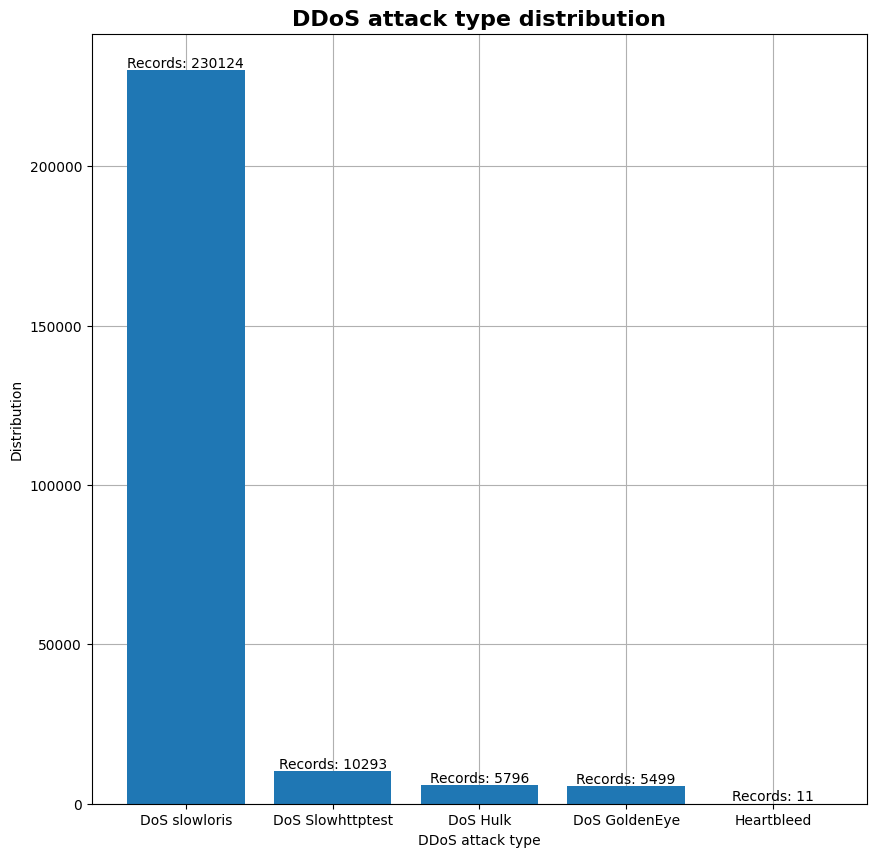

In [53]:
dos_plot(label, count)

# 4. Prepare data

In [19]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [20]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [21]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [22]:
len(y.unique())

15

## 4.1 Data Normalization

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10951643,
        -0.35707153, -0.33918443]])

## 4.2 Encode data

In [25]:
onehotencoder = OneHotEncoder()
y = y.values.reshape(-1, 1)
y = onehotencoder.fit_transform(y).toarray()
y = y[:, 0]

## 4.3 Principal component analysis

In [26]:
%%time
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
feature_selector = SelectKBest(score_func=f_classif, k='all')
X = feature_selector.fit_transform(X_pca, y)
X = X.reshape(X.shape[0], num_components, 1)

CPU times: user 4.34 s, sys: 1.47 s, total: 5.81 s
Wall time: 1.5 s


## 4.4 Save data

In [27]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 4.5 Load data

In [28]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [29]:
X

array([[[-2.20341917],
        [-0.04649812],
        [ 0.5388577 ],
        ...,
        [-0.18823211],
        [-0.24876228],
        [ 1.3845989 ]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       ...,

       [[ 2.96579199],
        [ 0.59986647],
        [-5.2269146 ],
        ...,
        [ 2.82679641],
        [ 0.33933268],
        [-0.2927417 ]],

       [[ 2.00624895],
        [ 0.45068367],
        [-4.21600076],
        ...,
        [ 2.46204332],
        [-0.01862949],
        [-0.30590085]],

       [[ 1.99913966],
        [ 0.43758331],
        [-4.20599781],
        ...,
        [ 2.45912152],
        [-0.02805093],
        [-0.30215974]]])

In [30]:
y

array([1., 1., 1., ..., 1., 1., 1.])

# 5. Create a model

Testing these models:
1. K Nearest Neighbour
2. Random Forest
3. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
4. Support Vector Machine;
5. Neural Network.

In [31]:
def visualize_CM(matrix, name):
    """
    Visualize Correlation Matrix
    """
    heatmap = sns.heatmap(matrix,annot=True)
    fig = heatmap.get_figure()
    fig.savefig(f"images/confusion_matrices/{name}.png")

In [32]:
results_dict = {}

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2403694, 10), (2403694,), (424182, 10), (424182,))

## 5.1. K Nearest Neighbour

In [34]:
%%time

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

CPU times: user 32.7 s, sys: 55.2 ms, total: 32.7 s
Wall time: 32.9 s


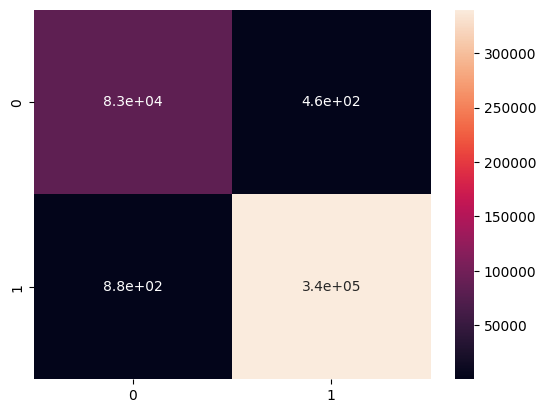

In [35]:
visualize_CM(confusion_matrix(y_test, y_pred), "kNN_CF")

In [36]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [37]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["KNN"] = results

In [38]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.0561


## 5.2. Random Forest

In [39]:
rf_params = {
    'n_estimators': 10,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': 'sqrt', 
    'max_leaf_nodes': None, 
    'bootstrap': True, 
    'oob_score': False,
    'n_jobs': 8, 
    'random_state': None,
    'verbose': 1, 
    'warm_start': False, 
    'class_weight': None
}

In [40]:
%%time

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   20.1s remaining:   13.4s


CPU times: user 2min 56s, sys: 666 ms, total: 2min 56s
Wall time: 33.7 s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   33.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


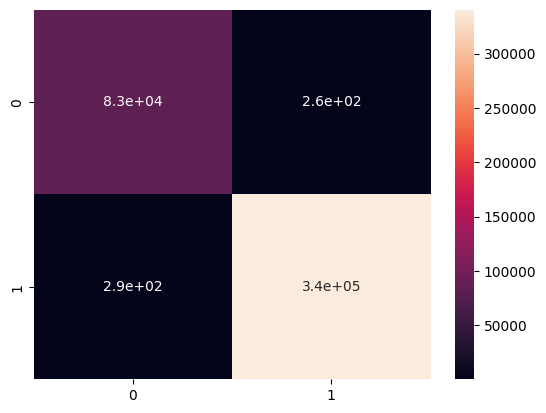

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred), "RF_CF")

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [43]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RF"] = results

In [44]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877


## 5.3. XGBoost

In [45]:
%%time

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

CPU times: user 53 s, sys: 90.2 ms, total: 53.1 s
Wall time: 7.35 s


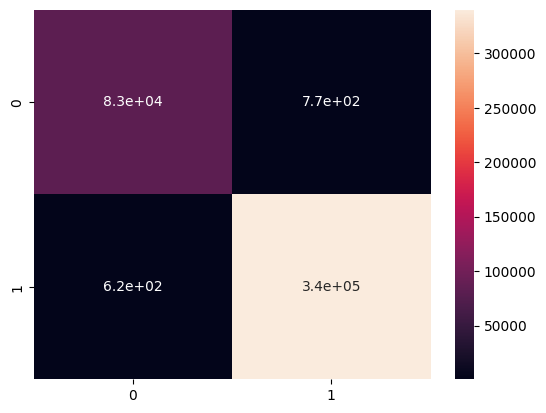

In [46]:
visualize_CM(confusion_matrix(y_test, y_pred), "XGBoost_CF")

In [47]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [48]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGBoost"] = results

In [49]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877
XGBoost,0.996735,0.996733,0.996734,0.996735,0.003265,0.003265,0.057141


## 5.4. LightGBM

In [50]:
%%time

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

[LightGBM] [Info] Number of positive: 1930537, number of negative: 473157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2403694, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803154 -> initscore=1.406126
[LightGBM] [Info] Start training from score 1.406126
CPU times: user 31 s, sys: 49.6 ms, total: 31.1 s
Wall time: 8.07 s


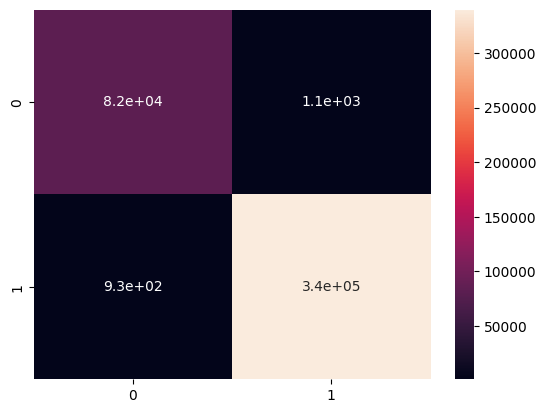

In [51]:
visualize_CM(confusion_matrix(y_test, y_pred), "LightGBM_CF")

In [52]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [53]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LightGBM"] = results

In [54]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877
XGBoost,0.996735,0.996733,0.996734,0.996735,0.003265,0.003265,0.057141
LightGBM,0.995144,0.995140,0.995141,0.995144,0.004856,0.004856,0.069688


## 5.5. Linear Support Vector Classifier

In [55]:
%%time

svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

CPU times: user 5.25 s, sys: 76.4 ms, total: 5.33 s
Wall time: 5.33 s


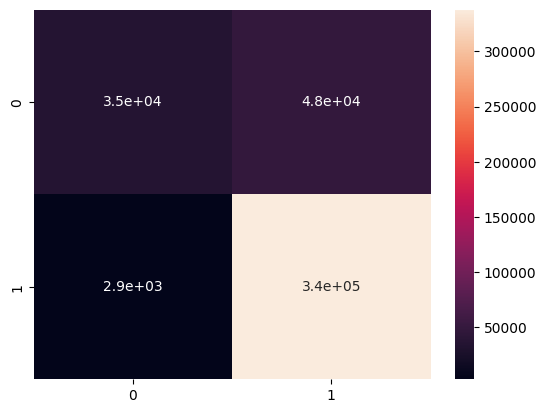

In [56]:
visualize_CM(confusion_matrix(y_test, y_pred), "LSVC_CF")

In [57]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [58]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LSVC"] = results

In [59]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877
XGBoost,0.996735,0.996733,0.996734,0.996735,0.003265,0.003265,0.057141
LightGBM,0.995144,0.995140,0.995141,0.995144,0.004856,0.004856,0.069688
LSVC,0.879460,0.884654,0.860732,0.879460,0.120540,0.120540,0.347189


## 5.6. Feed Forward Neural Network

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1971029, 10, 1),
 (1971029,),
 (432665, 10, 1),
 (432665,),
 (424182, 10, 1),
 (424182,))

In [61]:
def create_model_FFNN(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model_FFNN(X_train, y_train)

I0000 00:00:1736596703.548536  332385 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5023 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [62]:
y_train

array([1., 0., 1., ..., 1., 0., 1.])

In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,232 (270.44 KB)

 Trainable params: 69,232 (270.44 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
%%time
model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/20


I0000 00:00:1736596705.487004  334781 service.cc:148] XLA service 0x746d2800b3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736596705.487062  334781 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-01-11 13:58:25.518961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736596705.651351  334781 cuda_dnn.cc:529] Loaded cuDNN version 90600


   78/61595 ━━━━━━━━━━━━━━━━━━━━ 2:01 2ms/step - accuracy: 0.8806 - loss: 0.3424   

I0000 00:00:1736596706.418906  334781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61595/61595 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step - accuracy: 0.9629 - loss: 0.0901 - val_accuracy: 0.9768 - val_loss: 0.0554
Epoch 2/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 136s 2ms/step - accuracy: 0.9762 - loss: 0.0561 - val_accuracy: 0.9792 - val_loss: 0.0466
Epoch 3/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.9790 - loss: 0.0495 - val_accuracy: 0.9825 - val_loss: 0.0430
Epoch 4/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.9817 - loss: 0.0451 - val_accuracy: 0.9865 - val_loss: 0.0371
Epoch 5/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.9864 - loss: 0.0370 - val_accuracy: 0.9906 - val_loss: 0.0318
Epoch 6/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9875 - loss: 0.0351 - val_accuracy: 0.9887 - val_loss: 0.0330
Epoch 7/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9879 - loss: 0.0333 - val_accuracy: 0.9880 - val_loss: 0.0277
Epoch 8/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9

In [65]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step  


In [66]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9898 - loss: 0.0267


In [67]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["FF-NN"] = results

In [68]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

In [69]:
results_df

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877
XGBoost,0.996735,0.996733,0.996734,0.996735,0.003265,0.003265,0.057141
LightGBM,0.995144,0.995140,0.995141,0.995144,0.004856,0.004856,0.069688
LSVC,0.879460,0.884654,0.860732,0.879460,0.120540,0.120540,0.347189
FF-NN,0.989662,0.989634,0.989619,0.989662,0.010338,0.010338,0.101674


## 5.7. LSTM Neural Network

In [70]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [71]:
# Create sequences
seq_length = 20
X, y = create_sequences(X, y, seq_length)
y = to_categorical(y, num_classes=num_components)  # Convert labels to one-hot encoding

In [92]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [73]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [74]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X.shape[2]), num_classes=num_components)

In [75]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,378 (134.29 KB)

 Trainable params: 34,378 (134.29 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
%%time
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8192,
    validation_data=(X_val, y_val)
)

2025-01-11 15:35:40.620605: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.
2025-01-11 15:35:43.848431: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.


Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.9914 - loss: 0.0287 - val_accuracy: 0.9935 - val_loss: 0.0218
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.9791 - val_loss: 0.0540
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.9836 - loss: 0.0447 - val_accuracy: 0.9909 - val_loss: 0.0275
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accuracy: 0.9898 - loss: 0.0321 - val_accuracy: 0.9921 - val_loss: 0.0281
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.9917 - loss: 0.0277 - val_accuracy: 0.9878 - val_loss: 0.0349
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.9888 - loss: 0.0334 - val_accuracy: 0.9942 - val_loss: 0.0199
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.9918 - loss: 0.0275 - val_accuracy: 0.9922 - val_loss: 0.0244
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.9931 -

In [90]:
# Evaluate model
y_pred = model.predict(X_test)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step


In [93]:
_, accuracy = model.evaluate(X_test, y_test)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9937 - loss: 0.0182


In [94]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [95]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [96]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LSTM"] = results

In [97]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

In [98]:
results_df

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996853,0.996862,0.996856,0.996853,0.003147,0.003147,0.056100
RF,0.998713,0.998713,0.998713,0.998713,0.001287,0.001287,0.035877
XGBoost,0.996735,0.996733,0.996734,0.996735,0.003265,0.003265,0.057141
LightGBM,0.995144,0.995140,0.995141,0.995144,0.004856,0.004856,0.069688
LSVC,0.879460,0.884654,0.860732,0.879460,0.120540,0.120540,0.347189
FF-NN,0.989662,0.989634,0.989619,0.989662,0.010338,0.010338,0.101674
LSTM,0.993621,0.993643,0.993629,0.993621,0.006379,0.006379,0.079871


# 6. Plotting data

In [21]:
results = {
    "kNN": [0.996853, 0.996862, 0.996856, 0.996853, 0.003147, 0.003147, 0.056100],
    "RF": [0.998713, 0.998713, 0.998713, 0.998713, 0.001287, 0.001287, 0.035877],
    "XGBoost": [0.996735, 0.996733, 0.996734, 0.996735, 0.003265, 0.003265, 0.057141],
    "LightGBM": [0.995144, 0.995140, 0.995141, 0.995144, 0.004856, 0.004856, 0.069688],
    "LSVC": [0.879460, 0.884654, 0.860732, 0.879460, 0.120540, 0.120540, 0.347189],
    "FF-NN": [0.989662, 0.989634, 0.989619, 0.989662, 0.010338, 0.010338, 0.101674],
    "LSTM": [0.993621, 0.993643, 0.993629, 0.993621, 0.006379, 0.006379, 0.079871]
}
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

In [22]:
def dos_plot(label, count):
    _dict, attacks = [{} for x in range(2)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    rects = ax.patches
    labels = [f"Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('DDoS attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('DDoS attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/DDoS_attack_distribution.png")

In [27]:
def result_plot(_dict, name):
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall"]
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig(f"images/results/{name}.png")

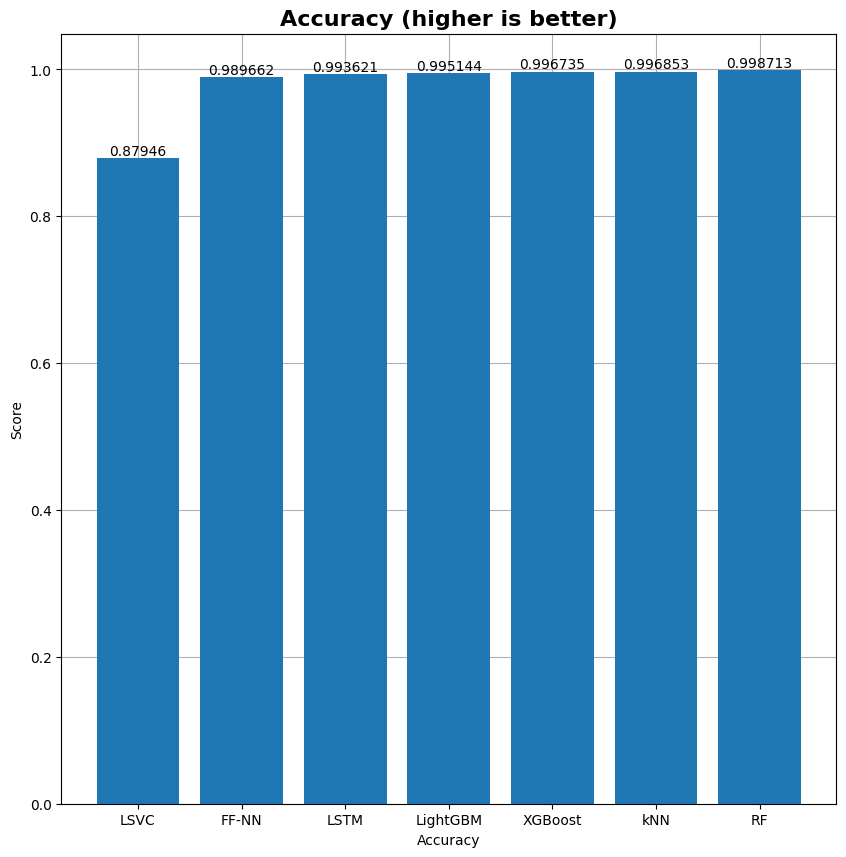

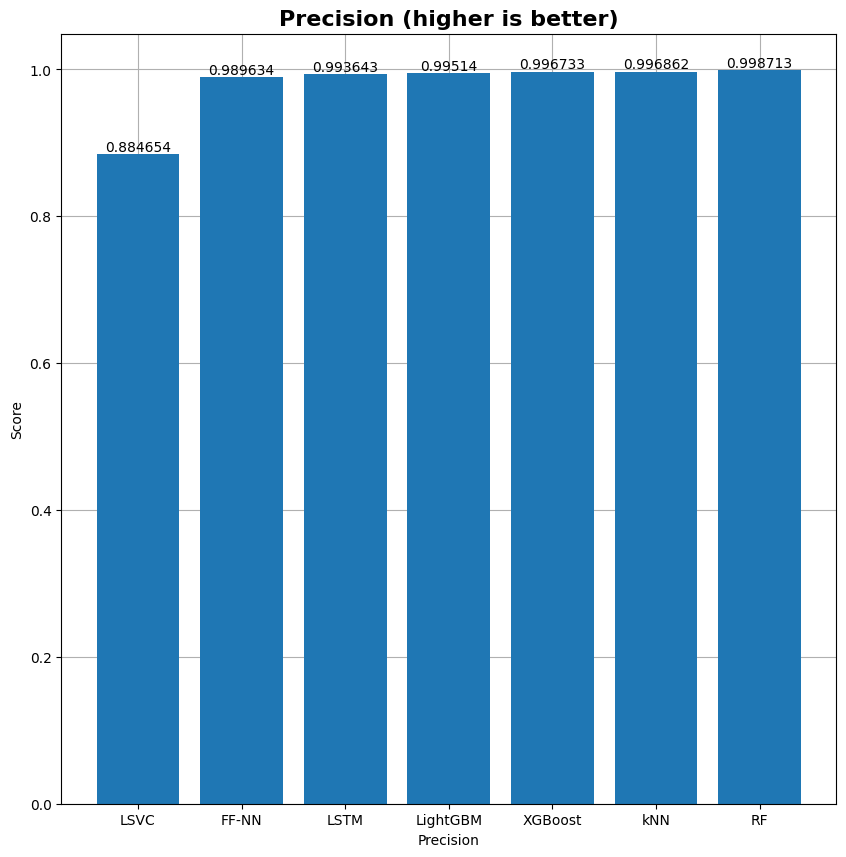

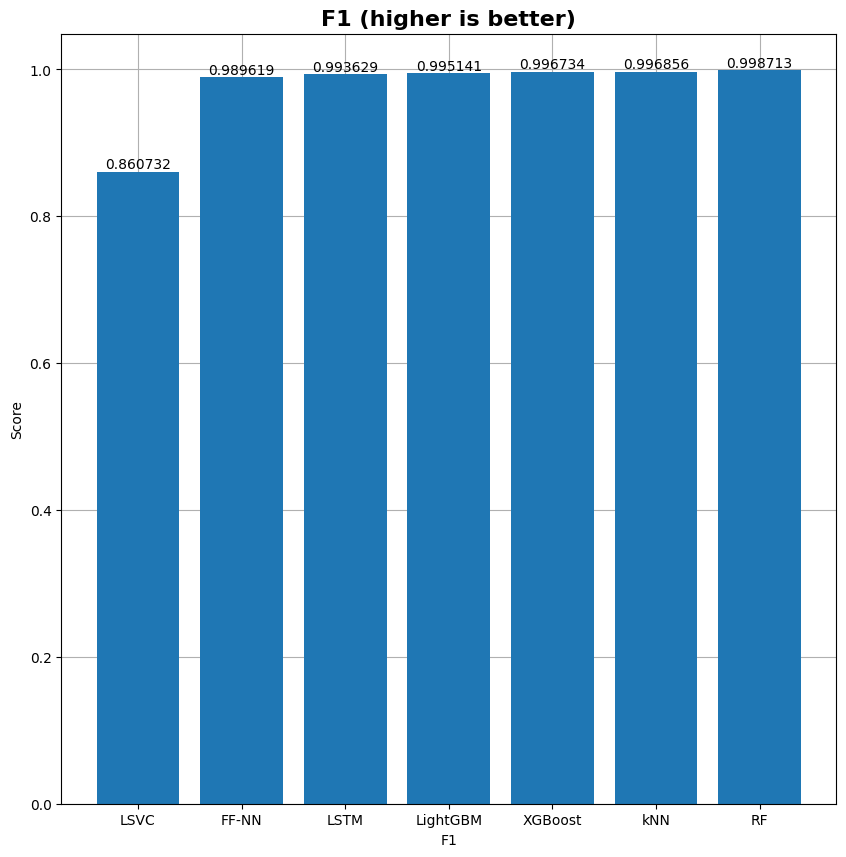

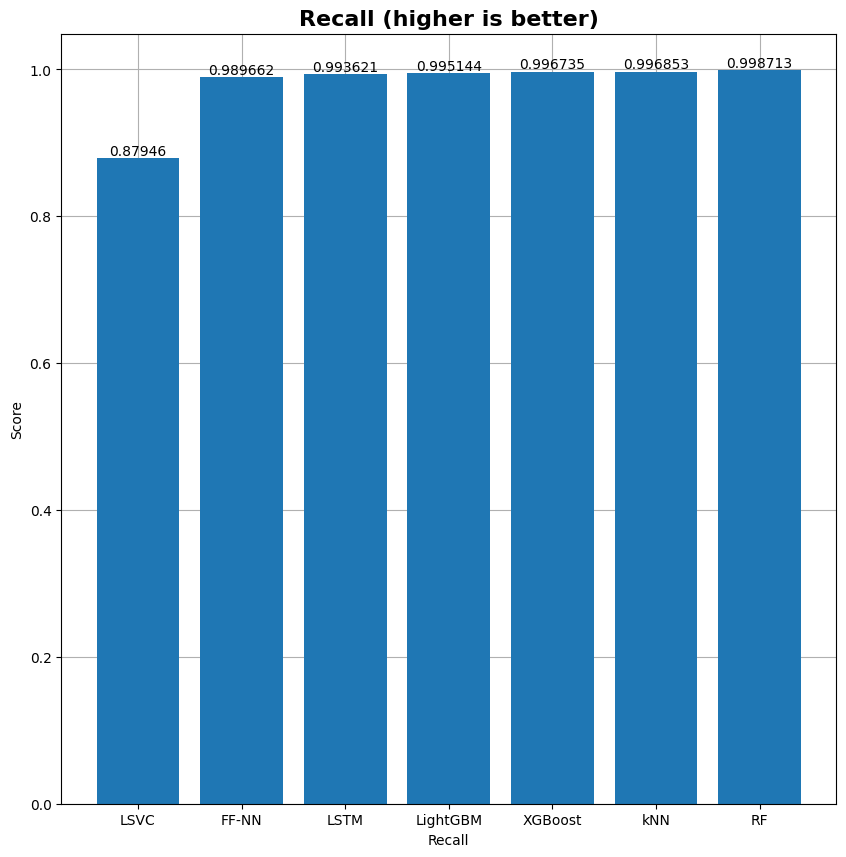

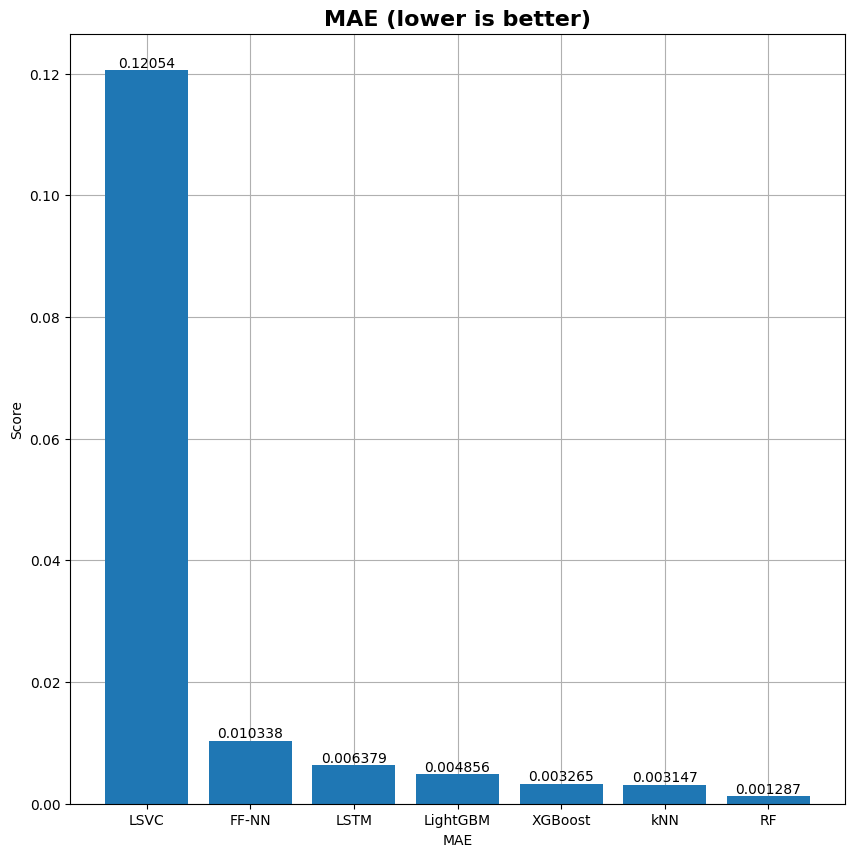

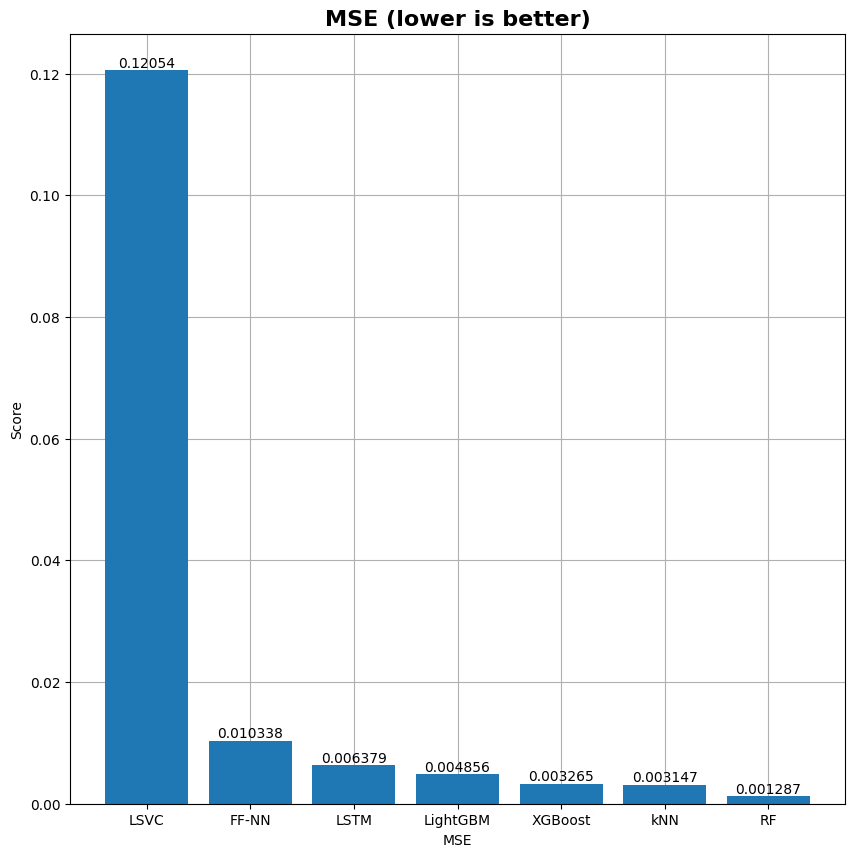

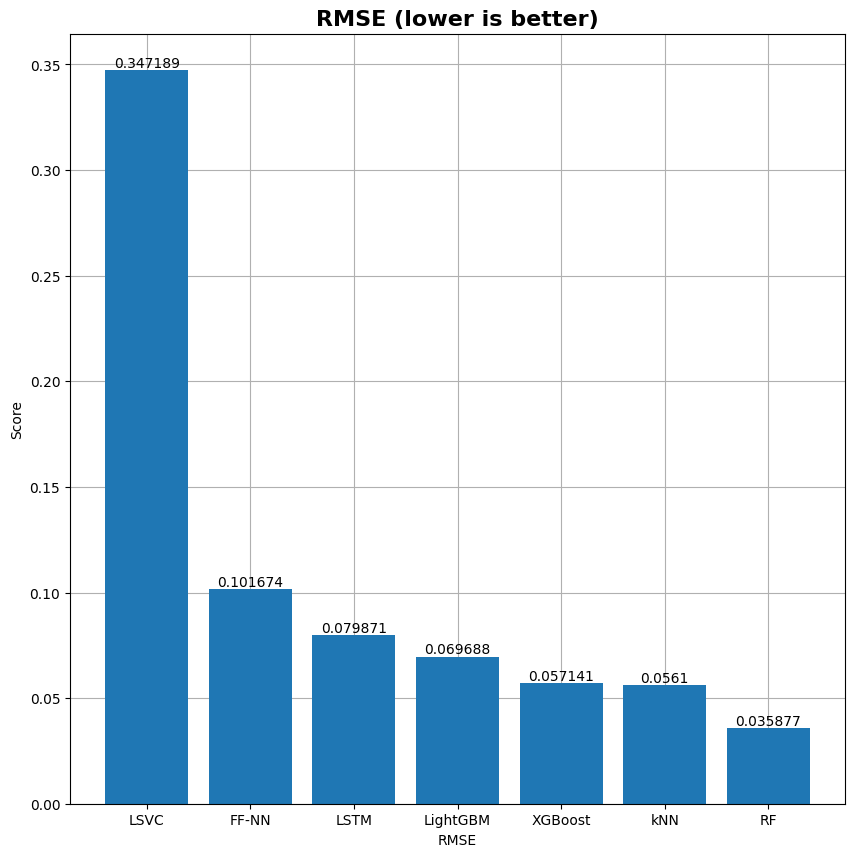

In [29]:
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name)